<div style="color:#3D5462;margin:0;font-size:60px;font-family:Meirio;text-align:center;display:fill;border-radius:6px;overflow:hidden;font-weight:700;"> AMP®-Parkinson's Disease Progression Prediction <br> </div>

<br>  

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>0. Table of Contents</b></div>



<div style="font-family:Meirio;background-color:whitesmoke; padding:30px; font-size:17px;color:#DB5461">
    
* [0. Table of Contents](#0)
* [1. Introduction](#1)
* [2. Imports](#2)
* [3. Library](#3)
    * [3.1 Functions](#3.1)
    * [3.2 Classes](#3.2)
* [4. Load data](#4)
* [5. Basic info](#5)
* [6. Exploratory Data Analysis](#6)
* [7. Preprocessing](#7)
* [8. Model Training](#8)
    * [Modeling](#8.2)
    * [Training](#8.3)
* [9. Explainability](#9)
    * [SHAP](#9.1)
* [10. Conclusion](#10)
* [11. Inferrence](#11)
* [12. Sources](#12)

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>1. Introduction</b></div>

## Goal of the Competition
The goal of this competition is to predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. The Movement Disorder Society-Sponsored Revision of the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) is a comprehensive assessment of both motor and non-motor symptoms associated with Parkinson's. You will develop a model trained on data of protein and peptide levels over time in subjects with Parkinson’s disease versus normal age-matched control subjects.

Your work could help provide important breakthrough information about which molecules change as Parkinson’s disease progresses.
##  Context
Parkinson’s disease (PD) is a disabling brain disorder that affects movements, cognition, sleep, and other normal functions. Unfortunately, there is no current cure—and the disease worsens over time. It's estimated that by 2037, 1.6 million people in the U.S. will have Parkinson’s disease, at an economic cost approaching $80 billion. Research indicates that protein or peptide abnormalities play a key role in the onset and worsening of this disease. Gaining a better understanding of this—with the help of data science—could provide important clues for the development of new pharmacotherapies to slow the progression or cure Parkinson’s disease.

Current efforts have resulted in complex clinical and neurobiological data on over 10,000 subjects for broad sharing with the research community. A number of important findings have been published using this data, but clear biomarkers or cures are still lacking.

Competition host, the Accelerating Medicines Partnership® Parkinson’s Disease (AMP®PD), is a public-private partnership between government, industry, and nonprofits that is managed through the Foundation of the National Institutes of Health (FNIH). The Partnership created the AMP PD Knowledge Platform, which includes a deep molecular characterization and longitudinal clinical profiling of Parkinson’s disease patients, with the goal of identifying and validating diagnostic, prognostic, and/or disease progression biomarkers for Parkinson’s disease.

Your work could help in the search for a cure for Parkinson’s disease, which would alleviate the substantial suffering and medical care costs of patients with this disease.


## Notes and todos from the author's

- [x]  Structure the notebook 
- [x] make a local compatible version
- [x] For the current XGBoost - solution, make a dictionary with models based on the prediction-horizons. This should be done with a discussion beforehand on how to do it
- [x] Clean up the code
- [x] Add SMAPE as the metric for the model
- [ ] Try a sipmler model with only visit_month=1
- [ ] Do better explainability-analysis on the simple model, and make a conclusion
- [ ] Simplyfy and modify the imputer code

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>2. Imports</b></div>

In [1]:
#!pip3 install mlflow
IS_ONLINE = False

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import os
import sys
import argparse
import logging
from sklearn.metrics import r2_score
import datetime
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
if IS_ONLINE:
    import amp_pd_peptide
else:
    import mock_api
import xgboost as xgb
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
#import mlflow
from pathlib import Path
# Run a SHAP analysis on all 4 models:
import shap



<a id="3"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>3. Library</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

<a id="3.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    3.1 Functions</span>

$$ \text{SMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|} \times 200\% $$


In [3]:
def smape(preds, dmatrix):
    labels = dmatrix.get_label()
    diff = np.abs(labels - preds) / (np.abs(labels) + np.abs(preds))
    diff = diff[~np.isnan(diff)]
    return 'SMAPE', float(np.mean(diff) * 200)

#### Some feature Engineering

In [4]:
def train(search_space, name, df_copy):
    """
    Train script with hyperparameters
    """

    def objective(search_space):
        """
        Encapsulated objective-function such that hyperopt function can reach input-data in objective function
        """
        global BEST_SMAPE
        global current_best_model
        dtrain = xgb.DMatrix(X_train.copy(), label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test.copy(), label=y_test, enable_categorical=True)
        evallist = [(dtest, "eval"), (dtrain, "train")]


        verbose_eval = 1000

        with mlflow.start_run(nested=True):
            num_round = 1000
            evals_result = {}
            num_features = 80
            bst = xgb.train(
                search_space,
                dtrain,
                num_round,
                evals=evallist,
                evals_result=evals_result,
                early_stopping_rounds=50,
                verbose_eval=verbose_eval,
                feval=smape,
            )
            print(f"Stopping after {len(evals_result['train']['SMAPE'])} rounds")

            min_eval_error = np.min(evals_result["eval"]["SMAPE"])
            mlflow.xgboost.log_model(bst, artifact_path="model")

            #Make the current_best_model global:
            print(min_eval_error,"min_eval_error")
            print(BEST_SMAPE)
            
            if min_eval_error < BEST_SMAPE:
                BEST_SMAPE = min_eval_error
                current_best_model = bst
            
        #return the best model together with status ok, attributes and the best model:
        return {'loss': min_eval_error, 'status': STATUS_OK, 'model': current_best_model, 'booster': bst.attributes()}
        

       


    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment(name)

    mlflow.xgboost.autolog(
        log_input_examples=False, log_model_signatures=True, log_models=True
    )

    df_copy = df_copy.copy()
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    X_cols = [col for col in df_copy.columns if col not in y_cols]
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
        # train only on the data where visit_month = months:
    X = X[X['visit_month'] == 0]
    #y indexes from X:
    y = y.loc[X.index]
    models_dict={}
    for i in y_cols:
        global BEST_SMAPE
        global current_best_model
        BEST_SMAPE = 100000
        current_best_model = None
        y_new = y[i]
        #Fill nan with mean:
        y_new = y_new.fillna(y_new.mean())

        # dividing X, y into train and test data. Random seed is specified in params dict form jsonfile
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_new, test_size=0.20, random_state=search_space["seed"]
        )

        # Use dataset shortname in run name along with model type. Better ideas?
        # import pathlib


        # -------INIT DONE----
        print("Dataset loaded, split into train test... ready to run hyperoptimalization!")

        with mlflow.start_run(run_name=f"xgb_{i}"):
            best_params = fmin(
                fn=objective,
                space=search_space,
                algo=tpe.suggest,
                max_evals=10,
            )
        print(best_params)
        # get the best model from the best params:
        best_model = current_best_model
            # save the best model to models_dict:
        models_dict[i] = best_model  
   
   
    return models_dict

In [5]:
def train_no_mlflow(search_space, name, df_copy):

    def objective(search_space):
        """
        Encapsulated objective-function such that hyperopt function can reach input-data in objective function
        """
        global BEST_SMAPE
        global current_best_model
        dtrain = xgb.DMatrix(X_train.copy(), label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test.copy(), label=y_test, enable_categorical=True)
        evallist = [(dtest, "eval"), (dtrain, "train")]


        verbose_eval = 1000

    
        num_round = 1000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=evallist,
            evals_result=evals_result,
            early_stopping_rounds=50,
            verbose_eval=verbose_eval,
            feval=smape,
        )
        print(f"Stopping after {len(evals_result['train']['SMAPE'])} rounds")
        min_eval_error = np.min(evals_result["eval"]["SMAPE"])

        #Make the current_best_model global:
        print(min_eval_error,"min_eval_error")
        print(BEST_SMAPE)
        
        if min_eval_error < BEST_SMAPE:
            BEST_SMAPE = min_eval_error
            current_best_model = bst
        
        #return the best model together with status ok, attributes and the best model:
        return {'loss': min_eval_error, 'status': STATUS_OK, 'model': current_best_model, 'booster': bst.attributes()}
        
    df_copy = df_copy.copy()
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    X_cols = [col for col in df_copy.columns if col not in y_cols]
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
    
    #y indexes from X:
    y = y.loc[X.index]  
    models_dict={}
    for i in y_cols:
        global BEST_SMAPE
        global current_best_model
        BEST_SMAPE = 100000
        current_best_model = None
        y_new = y[i]
        #Fill nan with mean:
        y_new = y_new.fillna(y_new.mean())

        # dividing X, y into train and test data. Random seed is specified in params dict form jsonfile
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_new, test_size=0.20, random_state=search_space["seed"]
        )

        # Use dataset shortname in run name along with model type. Better ideas?
        # import pathlib


        # -------INIT DONE----
        print("Dataset loaded, split into train test... ready to run hyperoptimalization!")

    
        best_params = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=10,
        )
        print(best_params)
        # get the best model from the best params:
        best_model = current_best_model
            # save the best model to models_dict:
        models_dict[i] = best_model
    return models_dict

In [6]:
def sum_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'sum'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceSum'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def std_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'std'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceStd'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def min_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'min'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMin'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def max_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'max'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMax'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def median_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'median'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMedian'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def count_peptides(df_peptides):
    df_peptides_count = df_peptides.groupby(['visit_id']).agg({'Peptide': 'count'}).reset_index()
    df_peptides_count.rename(columns={'Peptide': 'PeptideCount'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_count, on='visit_id', how='left')
    return df_peptides

# proteins feauture-engineering:
# dulicate the peptides feature-engineering functions for proteins, change PeptideAbundance to NPX:
def sum_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'sum'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXSum'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def std_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'std'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXStd'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def min_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'min'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMin'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def max_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'max'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMax'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def median_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'median'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMedian'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def count_proteins(df_proteins):
    df_proteins_count = df_proteins.groupby(['visit_id']).agg({'UniProt': 'count'}).reset_index()
    df_proteins_count.rename(columns={'UniProt': 'ProteinCount'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_count, on='visit_id', how='left')
    return df_proteins



def merge_peptides_to_clinical(df_peptides, df_clinical):
    """
    Merge the new features to the clinical dataframe.
    """
    
    # make a new dataframe with only visit_id and the new features:
    df_new = df_peptides[['visit_id', 'PeptideAbundanceSum', 'PeptideAbundanceStd', 'PeptideAbundanceMin', 'PeptideAbundanceMax', 'PeptideAbundanceMedian', 'PeptideCount']]
    # make df_peptides_new unique on visit_id:
    df_new = df_new.drop_duplicates(subset=['visit_id'])
    # merge the new features to the clinical dataframe:
    df_clinical = df_clinical.merge(df_new, on='visit_id', how='left')

    return df_clinical

def merge_proteins_to_clinical(df_proteins, df_clinical):
    """
    Merge the new features to the clinical dataframe.
    """
    # make a new dataframe with only visit_id and the new features:
    df_new = df_proteins[['visit_id', 'NPXSum', 'NPXStd', 'NPXMin', 'NPXMax', 'NPXMedian', 'ProteinCount']]
    # make df_peptides_new unique on visit_id:
    df_new = df_new.drop_duplicates(subset=['visit_id'])
    # merge the new features to the clinical dataframe:
    df_clinical = df_clinical.merge(df_new, on='visit_id', how='left')

    return df_clinical

        
    
        

In [7]:
def run_test_pipeline(df_peptides,df_proteins,df_test,imputer_path):
    df_peptides = sum_peptide_abundance(df_peptides)
    df_peptides = std_peptide_abundance(df_peptides)
    df_peptides = min_peptide_abundance(df_peptides)
    df_peptides = max_peptide_abundance(df_peptides)
    df_peptides = median_peptide_abundance(df_peptides)
    df_peptides = count_peptides(df_peptides)


    # feature engineering on Protein data:
    df_proteins = sum_protein_NPX(df_proteins)
    df_proteins = std_protein_NPX(df_proteins)
    df_proteins = min_protein_NPX(df_proteins)
    df_proteins = max_protein_NPX(df_proteins)
    df_proteins = median_protein_NPX(df_proteins)
    df_proteins = count_proteins(df_proteins)

    print("Done with feature engineering...")

    # Merge dataframes:
    df_test = merge_peptides_to_clinical(df_peptides, df_test)
    df_test = merge_proteins_to_clinical(df_proteins, df_test)

   
    # load pic
    
    imp_object = pickle.load(open(imputer_path, "rb"))
    
    # all cols: 
    #unpickle imputer:
    cols = ['visit_month','PeptideAbundanceSum','PeptideAbundanceStd','PeptideAbundanceMin','PeptideAbundanceMax','PeptideAbundanceMedian','PeptideCount','NPXSum','NPXStd','NPXMin','NPXMax','NPXMedian','ProteinCount']
    X_clinilcal = df_test[cols]
    X_rest = df_test.drop(cols,axis=1)
    X_clinilcal = imp_object.transform(X_clinilcal)
    # merge X_clinical and y_clinical:

    #make X_clinical a dataframe:
    X_clinilcal = pd.DataFrame(X_clinilcal,columns=cols)

    X_all = pd.concat([X_clinilcal, X_rest], axis=1)
    
    return X_all

In [8]:
def run_train_dataset_pipeline( imputer_path:str):
    """
    Description:
        Run the main processing pipeline.

    Input:
        - local_data_path: str, The path to the local data directory.

    Returns:
        - df: pd.DataFrame, A dataframe containing the output of the pipeline ready for training.
    """
    print("Starting train dataset pipeline...")

    df_peptides = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
    df_proteins = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
    df_clinical = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
    # feature engineering on Peptide data:
    df_peptides = sum_peptide_abundance(df_peptides)
    df_peptides = std_peptide_abundance(df_peptides)
    df_peptides = min_peptide_abundance(df_peptides)
    df_peptides = max_peptide_abundance(df_peptides)
    df_peptides = median_peptide_abundance(df_peptides)
    df_peptides = count_peptides(df_peptides)

    # feature engineering on Protein data:
    df_proteins = sum_protein_NPX(df_proteins)
    df_proteins = std_protein_NPX(df_proteins)
    df_proteins = min_protein_NPX(df_proteins)
    df_proteins = max_protein_NPX(df_proteins)
    df_proteins = median_protein_NPX(df_proteins)
    df_proteins = count_proteins(df_proteins)

    print("Done with feature engineering...")

    # Merge dataframes:
    df_clinical = merge_peptides_to_clinical(df_peptides, df_clinical)
    df_clinical = merge_proteins_to_clinical(df_proteins, df_clinical)

    # debug:
    #pritn all columns in df_clinical:
    print(df_clinical.columns)

    # Encode and Impute missing values:

    # remove ID columns:
    df_clinical = df_clinical.drop(columns=['visit_id', 'patient_id','upd23b_clinical_state_on_medication'])

 
    # initialize imputer object:
    imp_object = ImputeEncode(df_clinical, imputer_path)
    
    # fit transform imputer object:
    X_clinical,y_clinical = imp_object.fit_transform()   #  <-- returns X,y pd.DataFrames

    
    # merge X_clinical and y_clinical:
    df_clinical = pd.concat([X_clinical, y_clinical], axis=1)

    

    return df_clinical

In [9]:
def get_predictions_single_month_simple_imputer(models, peptides,proteins,test):
    """
    Function to get predictions from a list of models and a test set
    """
    
    # run test pipeline: 
    imputer_path = "../input/imputer/imputer.pkl"
    df_test = run_test_pipeline(peptides,proteins,test,imputer_path)

   
    result = pd.DataFrame()
    plus_months = [0,6,12,24]
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]

    #for unique patient_id:
    for visit_id in df_test["visit_id"].unique():
        for plus_month in plus_months:
            for udprs in y_cols:
                model = models[udprs] 
                #get the y_col:
                y_col = udprs
                #PREDICTION_ID: 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months
                prediction_id = str(visit_id) + "_" + y_col + "_" + "plus_" + str(plus_month) + "_months"
                
                #get the rating:
                #get the row from the df_test:
                df_test_row = df_test[df_test["visit_id"] == visit_id]
                #get the X_test:
                X_test = df_test_row[[  'visit_month',
                                        'PeptideAbundanceSum',
                                        'PeptideAbundanceStd',
                                        'PeptideAbundanceMin',
                                        'PeptideAbundanceMax',
                                        'PeptideAbundanceMedian',
                                        'PeptideCount',
                                        'NPXSum',
                                        'NPXStd',
                                        'NPXMin',
                                        'NPXMax',
                                        'NPXMedian',
                                        'ProteinCount']]
                #fill missing values with 0:
                X_test = X_test.fillna(0)
                X_test['visit_month'] = X_test['visit_month'] + plus_month
                
                #use concat instead of append, and dont pass group_key:
                result = pd.concat([result,pd.DataFrame({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},index=[0])],ignore_index=True)
    
    #if any of the predictions are negative, set them to 0:
    result.loc[result["rating"] < 0, "rating"] = 0
    return result

In [10]:
def get_predictions(models, peptides,proteins,test):
    """
    Function to get predictions from a list of models and a test set
    """
    # prediction_id = 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months"
    # define the smaple submission: 
    
    # run test pipeline: 
    imputer_path = "../input/imputer/imputer.pkl"
    #imputer_path = "../../config/imputer/preprocessor.pkl2023-03-14 12:43:15.199921preprocessor.pkl2023-03-15 12:58:42.803874"
    df_test = run_test_pipeline(peptides,proteins,test,imputer_path)

    # get predictions for each model:
    #if updrs_test = updrs_1, updrs_2, updrs_3, updrs_4: run the corresponding model: models[0], models[1], models[2], models[3]:
    # run each for the month 0, 6, 12, 24: where visit_month gets replaced = 0, 6, 12, 24
    # 
    result = pd.DataFrame()
    plus_months = [0,6,12,24]
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    LIST_OF_MODELMONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]
    #for unique patient_id:
    print(df_test["visit_id"].unique())
    print(df_test["visit_month"].unique())
    for visit_id in df_test["visit_id"].unique():
        for visit_month in df_test["visit_month"].unique():
            for udprs in y_cols:
                for plus_month in plus_months:
                
                    #get the model:
                    if plus_month+visit_month > 96:
                        model = models[udprs+"_"+str(96)]
                    
                    #if model is not in the list of models:
                    elif udprs+"_"+str(int(plus_month)+int(visit_month)) not in models:

                        model_nr = plus_month+visit_month
                        
                        for i in range(len(LIST_OF_MODELMONTHS)):
                            if LIST_OF_MODELMONTHS[i] > model_nr:
                                model = models[udprs+"_"+str(LIST_OF_MODELMONTHS[i-1])]


                    else:
                        model = models[udprs+"_"+str(int(plus_month)+int(visit_month))] # TODO change this line:
                    #get the y_col:
                    y_col = udprs
                    #PREDICTION_ID: 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months
                    prediction_id = str(visit_id) + "_" + y_col + "_" + "plus_" + str(plus_month) + "_months"
                    #get the group_key:
                    #get the rating:
                    #get the row from the df_test:
                    df_test_row = df_test[df_test["visit_id"] == visit_id]
                    #get the X_test:
                    X_test = df_test_row[['visit_month',
                                            'PeptideAbundanceSum',
                                            'PeptideAbundanceStd',
                                            'PeptideAbundanceMin',
                                            'PeptideAbundanceMax',
                                            'PeptideAbundanceMedian',
                                            'PeptideCount',
                                            'NPXSum',
                                            'NPXStd',
                                            'NPXMin',
                                            'NPXMax',
                                            'NPXMedian',
                                            'ProteinCount']]
                    #fill missing values with 0:
                    X_test = X_test.fillna(0)
                    X_test['visit_month'] = X_test['visit_month'] + plus_month
                    
                    # use the correct model to predict:
                    #
                    #result = result.append({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},ignore_index=True)#,"group_key":group_key},ignore_index=True)

                    #use concat instead of append, and dont pass group_key:
                    result = pd.concat([result,pd.DataFrame({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},index=[0])],ignore_index=True)
    
            
            
        


    
        
        
    

    return result #pd.DataFrame: | prediction_id | rating | group_key |

<a id="3.2"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    3.2 Classes</span>
    
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

In [11]:

class ImputeEncode():
    """
    Impute missing values, and encode variables.
    Columns of dtype object are imputed with the most frequent value
    in column.
    Columns of other types are imputed with median of column.
    """
    def __init__(self,df, imputer_path, **kwargs):
        self.ISKAGGLE=True
        self.X_cols = [col for col in df.columns if col not in ['updrs_1','updrs_2','updrs_3','updrs_4']]
        self.y_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
        self.X = df[self.X_cols]
        self.y = df[self.y_cols]
        self.categorical_pipeline = None
        self.numerical_pipeline = None
        self.preprocessor = None
        self.imputer_path = imputer_path
        self.categorical_columns = [col for col in self.X.columns if self.X[col].dtype == 'object']
        self.numerical_columns = [col for col in self.X.columns if self.X[col].dtype != 'object']
        self.preprocessor_y = None
        # if kwargs containes a string to a imputer file load it with pickle and assign it to self.preprocessor
        if 'imputer_path_file' in kwargs:
            self.preprocessor = pickle.load(open(kwargs['imputer_path_file'], 'rb'))


    def fit(self):
        """
        Take in a X: pandas dataframe, and return self.

        Parameters:
        X (pandas dataframe): The dataframe to fit the imputer on.
        y (pandas series): The target variable.

        Returns:
        X (pandas dataframe): The dataframe with imputed values.
        y (pandas series): The target variable with imputed values.
        """
        # run a impute and encode pipeline on the categorical columns:
        self.categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
        # run a impute and encode pipeline on the numerical columns:
        self.numerical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        # combine the categorical and numerical pipelines:
        self.preprocessor = ColumnTransformer([
            ('categorical', self.categorical_pipeline, self.categorical_columns),
            ('numerical', self.numerical_pipeline, self.numerical_columns)
        ])
        # fit the preprocessor:
        self.preprocessor.fit(self.X, self.y)
        
        # save the preprocessor to pickle:
        # path to save it to: config/pickles/preprocessor.pkl
        # check if the directory exists, if not, create it:
        if self.ISKAGGLEis ==True:
            print("skipping model save")
        else:
            
            if not os.path.exists(self.imputer_path):
                os.makedirs(self.imputer_path)
            # save the preprocessor to pickle:
            FILENAME = 'preprocessor.pkl' + str(datetime.datetime.now())
            with open(self.imputer_path + FILENAME, 'wb') as f:
                pickle.dump(self.preprocessor, f)

        
        # return the imputed and encoded X and y as dataframes:

        return self.preprocessor
    

    def fit_transform(self):
        """
        Take in a X: pandas dataframe, and return self.
        """
        #encode:
        X = self.X
        y = self.y
        #fit:
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.preprocessor = imp.fit(X)
        X = imp.transform(X)
        if self.ISKAGGLE ==True:
            print("skippping")
        else:
            # save the preprocessor to pickle:
            if not os.path.exists(self.imputer_path):
                os.makedirs(self.imputer_path)

            FILENAME = str(datetime.datetime.now()) + 'preprocessor.pkl'
            with open(self.imputer_path + FILENAME, 'wb') as f:
                pickle.dump(self.preprocessor, f)

        self.preprocessor_y = imp.fit(y)
        
        #transform and return:
        X = pd.DataFrame(X, columns=self.X_cols)
        y = pd.DataFrame(y, columns=self.y_cols)

        return X,y
    
    def fit_transform_simple(self):
        """
        Take in a X: pandas dataframe, and return self. No functional difference from fit_transform, but functionality will be added later.
        """

        #encode:
        X = self.X
        y = self.y

        #fit:
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.preprocessor = imp.fit(X)
        X = imp.transform(X)

        # save the preprocessor to pickle:
        if not os.path.exists(self.imputer_path):
            os.makedirs(self.imputer_path)
            
        FILENAME = str(datetime.datetime.now()) + 'preprocessor.pkl'
        with open(self.imputer_path + FILENAME, 'wb') as f:
            pickle.dump(self.preprocessor, f)

        self.preprocessor_y = imp.fit(y)
        
        #transform and return:
        X = pd.DataFrame(X, columns=self.X_cols)
        y = pd.DataFrame(y, columns=self.y_cols)

        return X,y
        


<a id="4"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>4. Load Data</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>


<a id="5"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>5. Basic dataset infofmation</b></div>

<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

    

Cerebrospinal fluid (CSF, shown in blue) is made by tissue that lines the ventricles (hollow spaces) in the brain. It flows in and around the brain and spinal cord to help cushion them from injury and provide nutrients.

<a id="6"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>6. Exploratory Data Analysis</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>



 **Data description df_peptides**

**Description:**
df_peptides.csv Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

From: 
df_peptides.csv
1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **UniProt** - The UniProt ID code for the associated protein. There are often several peptides per protein.
5. **Peptide** - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table.
6. **PeptideAbundance** - The frequency of the amino acid in the sample.



**Data description df_proteins**
**Description:**
Protein expression frequencies aggregated from the peptide level data.
From:
train_proteins.csv 

1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **UniProt** - The UniProt ID code for the associated protein. There are often several peptides per protein.
5. **NPX** - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.
 

**Data description df_clinical_data**
**Description:**
Clinical data for each patient. This data is collected at the time of the visit.
From:
train_clinical_data.csv

1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **updrs_[1-4]** - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
5. upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.




In [12]:
# load the 3 datasets:
df_peptides_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
df_proteins_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
df_clinical_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")




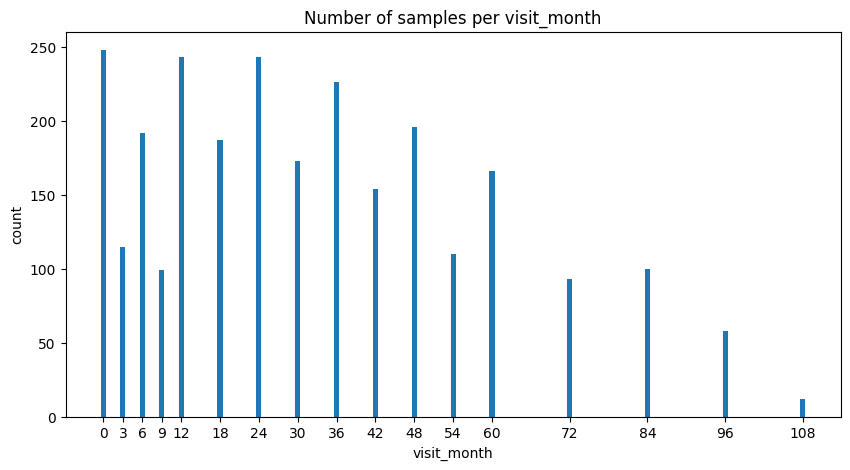

In [13]:
# count number of samples where visit_month = [0,6,12,18,24,30] respectively:
a = df_clinical_EDA['visit_month'].value_counts()

# plot it and make the months cronological on the x-axis:
plt.figure(figsize=(10,5))
plt.bar(a.index,a.values)
plt.xticks(a.index)
plt.xlabel('visit_month')
plt.ylabel('count')
plt.title('Number of samples per visit_month')
plt.show()



Number of samples per month decreases significantly, thus we have to be smart about choosing a time-series predictor model

In [1]:
df_EDA = run_train_dataset_pipeline( imputer_path)

NameError: name 'run_train_dataset_pipeline' is not defined

<a id="7"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>7. Data Preprocessing</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    
    
    All the data preprocessing are defined in functions and is called from the run_pipeline function

In [14]:
# Define args to pipeline:
local_data_path = "data/raw/"
test_data_path = "data/test/example_test_files/"
imputer_path = "../input/imputer/"
is_test= False

In [15]:
df = run_train_dataset_pipeline( imputer_path)

Starting train dataset pipeline...
Done with feature engineering...
Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication',
       'PeptideAbundanceSum', 'PeptideAbundanceStd', 'PeptideAbundanceMin',
       'PeptideAbundanceMax', 'PeptideAbundanceMedian', 'PeptideCount',
       'NPXSum', 'NPXStd', 'NPXMin', 'NPXMax', 'NPXMedian', 'ProteinCount'],
      dtype='object')
skippping


<a id="8"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>8. Model Training</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="8.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    8.1 Modeling </span>

<a id="8.2"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    8.2 Training </span>
    
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

In [16]:
# ENSAMBLE MODEL FOR MULTIMONTH CLASSIFICATION: 


"""
models = {}
MONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]

df_copy = df.copy()
y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
X_cols = [col for col in df_copy.columns if col not in y_cols]

for month in MONTHS:
    
   
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
        # train only on the data where visit_month = months:
    X = X[X['visit_month'] == month]


    print("The model with month:",month,"has : ",X.shape[0],"samples")
    # make the y_train dataframe be made from the index of the X_train dataframe:
    y = y.loc[X.index]

    # do a train test split on the train data:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     #fill missing values with 0:
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    #fill missing values with 0:
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    for y_col in y_cols:
        
        print("Training model for y_col: {}".format(y_col))
        y_train_new = y_train[y_col]
        y_test_new = y_test[y_col]

        dtrain = xgb.DMatrix(X_train, label=y_train_new)
        dtest = xgb.DMatrix(X_test, label=y_test_new)
        evallist = [(dtest, "eval"), (dtrain, "train")]

        params = {
            "eval_metric": "rmse",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "seed": 42
        }
        num_round = 1000
        evals_result = {}
        #turn on logging every 50 iterations:
        verbose_eval = 0
        model = xgb.train(
            params,
            dtrain,
            num_round,
            evallist,
            evals_result=evals_result,
            early_stopping_rounds=10,
            verbose_eval=verbose_eval,
            custom_metric=smape
        )
        models[y_col+"_"+str(month)] = model
        #calculate r2 score for each model:
        y_pred = model.predict(dtest)
        r2 = r2_score(y_test_new, y_pred)
        print("R2 score for model: {}".format(r2))

"""

'\nmodels = {}\nMONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]\n\ndf_copy = df.copy()\ny_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]\nX_cols = [col for col in df_copy.columns if col not in y_cols]\n\nfor month in MONTHS:\n    \n   \n    # Define X and y:\n    X = df_copy[X_cols]\n    y = df_copy[y_cols]\n        # train only on the data where visit_month = months:\n    X = X[X[\'visit_month\'] == month]\n\n\n    print("The model with month:",month,"has : ",X.shape[0],"samples")\n    # make the y_train dataframe be made from the index of the X_train dataframe:\n    y = y.loc[X.index]\n\n    # do a train test split on the train data:\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n     #fill missing values with 0:\n    X_train = X_train.fillna(0)\n    X_test = X_test.fillna(0)\n\n    #fill missing values with 0:\n    y_train = y_train.fillna(0)\n    y_test = y_test.fillna(0)\n\n    for y_col in y_cols:\n        \n        print("Tra

In [17]:
# 4 SIMPLE MODELS FOR 1 MONTH CLASSIFICATION:

""""""
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


models = {}
df_copy = df.copy()
y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
X_cols = [col for col in df_copy.columns if col not in y_cols]

search_space = {
        "eval_metric": "rmse",
        "eta": hp.uniform("eta", 0.01, 0.5),
        "max_depth": hp.choice("max_depth", np.arange(1, 5, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 10),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "lambda": hp.uniform("lambda", 0, 2),
        "alpha": hp.uniform("alpha", 0, 2),
        "seed": 42
    }

name ="test"

models_dicts = train_no_mlflow(search_space, name, df_copy)


    

Dataset loaded, split into train test... ready to run hyperoptimalization!
[0]	eval-rmse:8.37405	eval-SMAPE:143.70978	train-rmse:8.42256	train-SMAPE:145.10135
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

`feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.



[999]	eval-rmse:5.74114	eval-SMAPE:71.12259	train-rmse:5.19150	train-SMAPE:64.16433
Stopping after 1000 rounds                            
70.188779                                             
min_eval_error                                        
100000                                                
[0]	eval-rmse:6.72980	eval-SMAPE:85.09100	train-rmse:6.66438	train-SMAPE:82.26375
[999]	eval-rmse:6.16831	eval-SMAPE:76.61999	train-rmse:4.25073	train-SMAPE:49.50292
Stopping after 1000 rounds                                             
70.659357                                                              
min_eval_error                                                         
70.188779                                                              
[0]	eval-rmse:6.85860	eval-SMAPE:87.70293	train-rmse:6.78979	train-SMAPE:85.16931
[999]	eval-rmse:5.97586	eval-SMAPE:72.75948	train-rmse:4.18871	train-SMAPE:43.43021
Stopping after 1000 rounds                                             
70.4

In [18]:
models_dicts

{'updrs_1': <xgboost.core.Booster at 0x2a169eef0>,
 'updrs_2': <xgboost.core.Booster at 0x2a169f2e0>,
 'updrs_3': <xgboost.core.Booster at 0x2a167ef80>,
 'updrs_4': <xgboost.core.Booster at 0x2a167f880>}

In [19]:
test_data_path = "../input/amp-parkinsons-disease-progression-prediction/example_test_files/"
df_peptides_test = pd.read_csv(test_data_path + "test_peptides.csv")
df_proteins_test = pd.read_csv(test_data_path + "test_proteins.csv")
df_clinical_test = pd.read_csv(test_data_path + "test.csv")
imputer_path = "../input/imputer/imputer.pkl"
df_test = run_test_pipeline(df_peptides_test,df_proteins_test,df_clinical_test,imputer_path)




Done with feature engineering...


In [20]:

df_test = df_test[[ 'visit_month',
                    'PeptideAbundanceSum',
                    'PeptideAbundanceStd',
                    'PeptideAbundanceMin',
                    'PeptideAbundanceMax',
                    'PeptideAbundanceMedian',
                    'PeptideCount',
                    'NPXSum',
                    'NPXStd',
                    'NPXMin',
                    'NPXMax',
                    'NPXMedian',
                    'ProteinCount']]

df_test = df_test.fillna(0)

#make a prediction on the first row of the test data:



<a id="9"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>9. Explainability</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="9.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    9.1 SHAP </span>

In [21]:
#load JS visualization code to notebook
if ~IS_ONLINE:
    shap.initjs()






[0.5]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


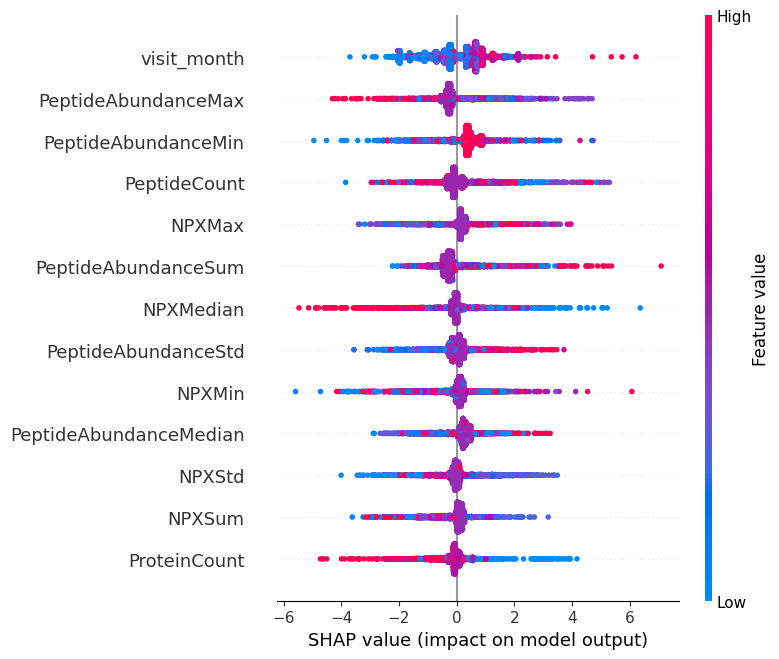

In [ ]:
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
if ~IS_ONLINE:
    explainer = shap.TreeExplainer(models_dicts["updrs_1"])
    #print
    print(explainer.expected_value)
    # calculate shap values. This is what we will plot.

    shap_values = explainer.shap_values(df_copy[X_cols])

    # plot the feature attributions
    shap.summary_plot(shap_values, df_copy[X_cols])

<a id="10"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>10. Conclusion</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="11"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>11. Inferrence</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

In [ ]:
if IS_ONLINE:
    env = amp_pd_peptide.make_env()   # initialize the environment
else:
    env = mock_api.make_env()   # initialize the environment
iter_test = env.iter_test()  

for (test,test_peptides,test_proteins,sample_submission) in iter_test:
    preds = get_predictions_single_month_simple_imputer(models_dicts,test_peptides,test_proteins,test)
    env.predict(preds)
    print(preds)

Done with feature engineering...
                     prediction_id     rating
0     3342_0_updrs_1_plus_0_months   6.284033
1     3342_0_updrs_2_plus_0_months   5.811751
2     3342_0_updrs_3_plus_0_months  16.431808
3     3342_0_updrs_4_plus_0_months   1.878937
4     3342_0_updrs_1_plus_6_months   6.933555
5     3342_0_updrs_2_plus_6_months   5.603242
6     3342_0_updrs_3_plus_6_months  15.739985
7     3342_0_updrs_4_plus_6_months   1.878937
8    3342_0_updrs_1_plus_12_months   5.218391
9    3342_0_updrs_2_plus_12_months   4.580685
10   3342_0_updrs_3_plus_12_months  14.849056
11   3342_0_updrs_4_plus_12_months   1.588225
12   3342_0_updrs_1_plus_24_months   6.526637
13   3342_0_updrs_2_plus_24_months   5.079721
14   3342_0_updrs_3_plus_24_months  16.325144
15   3342_0_updrs_4_plus_24_months   1.588225
16   50423_0_updrs_1_plus_0_months   8.968407
17   50423_0_updrs_2_plus_0_months   0.466647
18   50423_0_updrs_3_plus_0_months  34.902802
19   50423_0_updrs_4_plus_0_months   1.900827
2

<a id="12"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>12. Sources</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

1. Colours and colour - palette from: https://coolors.co/db5461-686963-8aa29e-3d5467-f1edee